In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np

from IPython.display import display, HTML
import h5py


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 18
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [3]:
from scipy.fft import fft, ifft

def get_snr_frac(decoded_signal, pure_signal, signal_type):
    
    if(signal_type == 'injection'):
    
        h_fft = fft(pure_signal)
        template_fft = fft(pure_signal)
        snr_freq = (h_fft * template_fft.conjugate())
        snr_time = np.abs(ifft(snr_freq))
        optimal_snr_ligo = np.sqrt(np.max(snr_time))
    
        h_fft = fft(decoded_signal)
        template_fft = fft(decoded_signal)
        snr_freq = (h_fft * template_fft.conjugate())
        snr_time = np.abs(ifft(snr_freq))
        optimal_snr_ml = np.sqrt(np.max(snr_time))

        return optimal_snr_ml/optimal_snr_ligo
    
    elif(signal_type == 'pure_noise'):
        
        h_fft = fft(decoded_signal)
        template_fft = fft(decoded_signal)
        snr_freq = (h_fft * template_fft.conjugate())
        snr_time = np.abs(ifft(snr_freq))
        optimal_snr_ml = np.sqrt(np.max(snr_time))
        
        return optimal_snr_ml


In [4]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, strain, m1, m2, snr):
    
    time_buffer = 4
    length_signal = len(decoded_signals)

    f_low = 18
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = sample_rate * time_buffer
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/2048)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
        signal_type = 'injection'
    else:
        m = 1
        signal_type = 'pure_noise'
    
    snr_opt = get_snr_frac(decoded_signals.squeeze(), pure_signals, signal_type=signal_type)
    
    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.80, 0.20, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
#    signal_axes.set_ylim(-1.1, 1.1)
    signal_axes.set_title('Mass1 = {m1}, Mass2 = {m2}, S/N = {snr}, Overlap = {m}, SNR_opt = {snr_opt}'.format(m1=np.round(m1,2), m2=np.round(m2,2), snr=np.round(snr,2), m=np.round(m,2), snr_opt=np.round(snr_opt,2)))
#    signal_axes.plot(time,strain.squeeze(), linewidth=1.2, label ='Whitened Livingston strain', alpha=0.5)
    signal_axes.plot(time,pure_signals.squeeze(), linewidth=1.2, label ='Pure Livingston signal')
    signal_axes.plot(time,decoded_signals.squeeze(), linewidth=1.2, label ='Denoised Livingston signal', c='red', linestyle='dashed')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()

#    plt.savefig('IMBH_test/IMRPhenomXPHM_O3b_signal+noise/Chirp_mass_test/Mchirp_10to20/SNR-30to40/Weighted_loss_Plot_m1-'+str(int(m1))+'_m2-'+str(int(m2))+'_snr-'+str(int(snr))+'.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)
#    plt.savefig('IMBH_test/IMRPhenomXPHM_O3b_signal+noise/Chirp_mass_test/Test_SNR/Weighted_loss_Plot_m1-'+str(int(m1))+'_m2-'+str(int(m2))+'_snr-'+str(int(snr))+'.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)
   

# Load model - dilated CNN, 25 timesteps, MSE+MAE+FT loss

In [5]:
import tensorflow as tf

class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

# SNR - 8 to 10

<ipython-input-6-a1e132946dd5>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


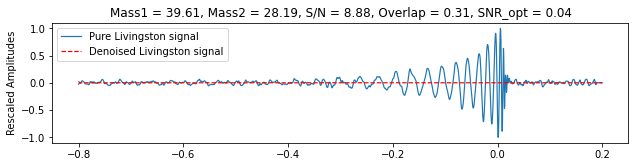

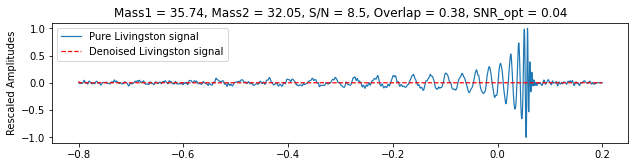

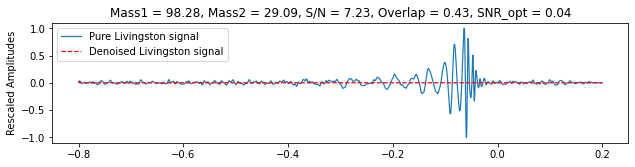

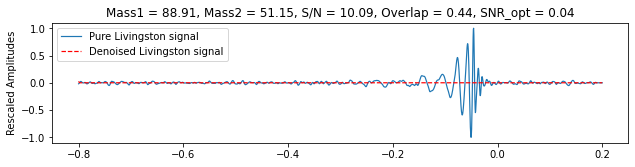

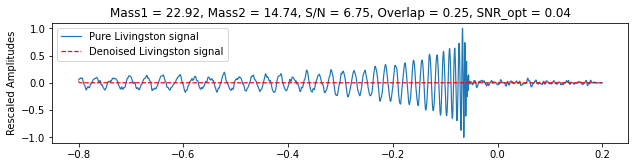

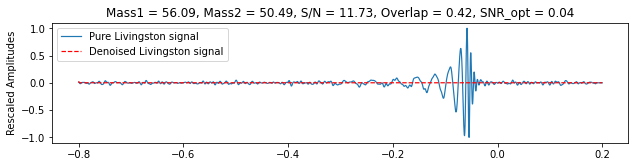

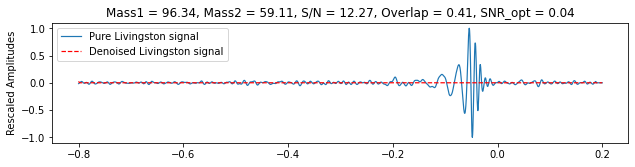

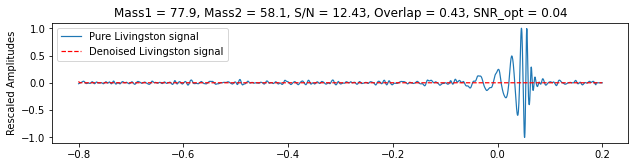

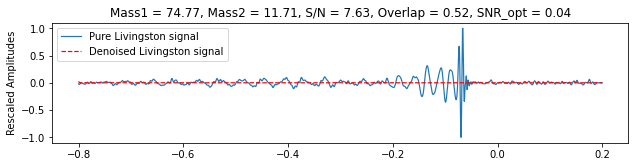

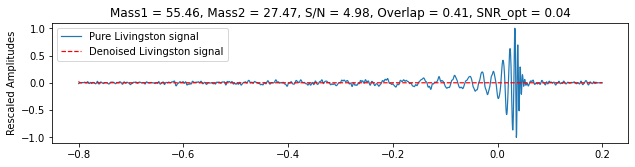

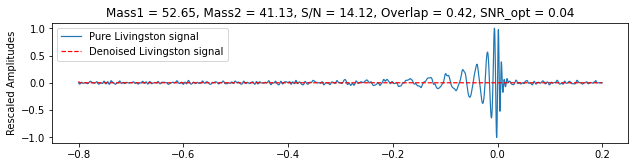

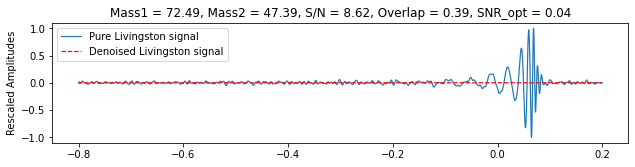

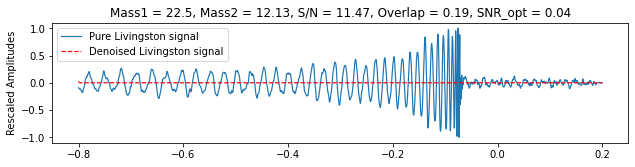

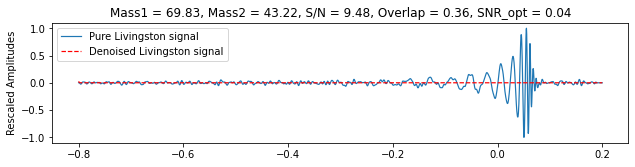

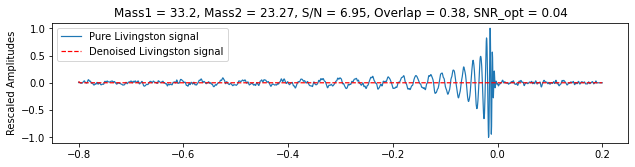

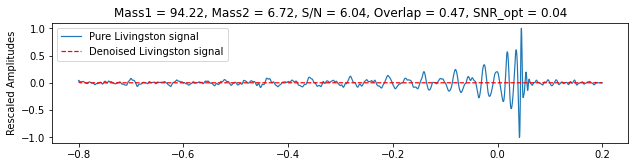

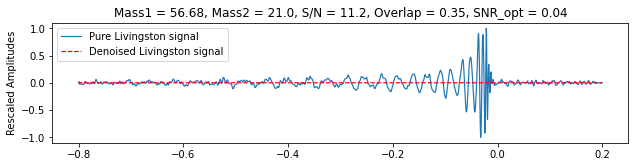

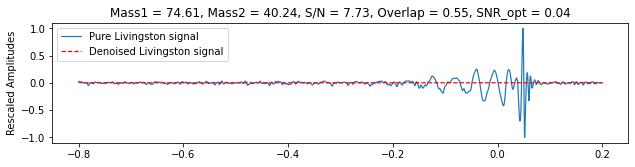

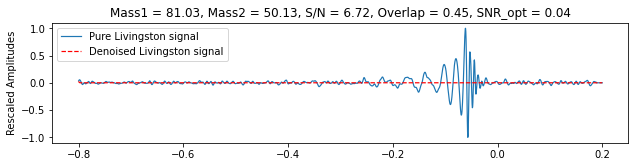

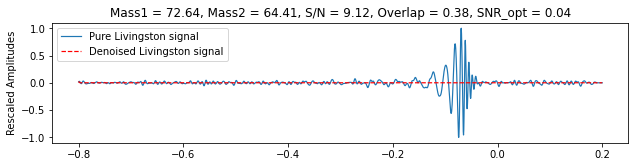

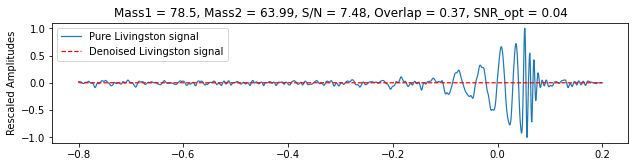

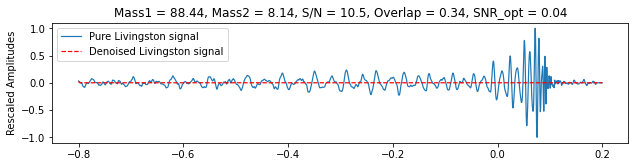

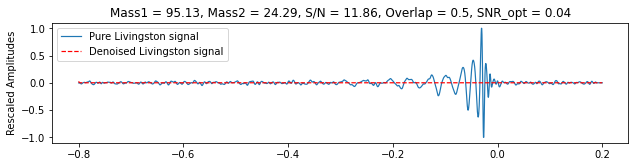

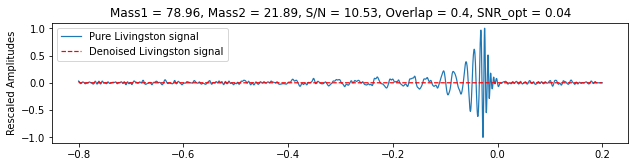

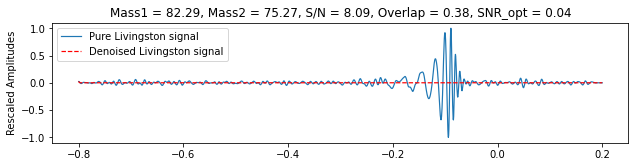

In [7]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMRPhenomXPHM_25_tsteps_O3b_SNR-8to40_mchirp-all_dilated_CNN_trainable_loss.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/O3b_test_IMRPhenomXPHM_SNR-8to10_mchirp_all_whitening_fixed.hdf", "r")

noise_index = range(100,125)
signal_index = range(25)
j = -1
   
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)
    
    j+=1
    
    strain = np.pad(f2['injection_samples']['l1_strain'][j].astype(np.float64), (12,13), constant_values=(0,0))
    
    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][j]*f2['injection_parameters']['scale_factor'][j]
    
    plot_reconstructed(decoded_signals, pure_signals, strain, m1, m2, snr)

#j = -1

#for i in range(100,125):
    
#    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
#    pure_signals = f1['pure_signals'][i].astype(np.float64)
    
#    j+=1
#    strain = np.pad(f2['noise_samples']['l1_strain'][j].astype(np.float64), (5,5), constant_values=(0,0))
    
#    m1 = 999 + i
#    m2 = 999 + i
#    snr = 999 + i
        
#    plot_reconstructed(decoded_signals, pure_signals, strain, m1, m2, snr)
    